# UI Segmentation Dataset EDA


In [1]:
from pathlib import Path
from collections import defaultdict
import random

import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

try:
    import pandas as pd
except ImportError:
    pd = None

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 120

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Load dataset configuration


In [2]:
DATASET_DIR = Path("./dataset")
SPLITS = ["train", "valid", "test"]
yaml_path = DATASET_DIR / "data.yaml"

assert DATASET_DIR.exists(), f"Dataset directory not found: {DATASET_DIR.resolve()}"
assert yaml_path.exists(), f"Missing {yaml_path}. Run your dataset download step first."

with open(yaml_path, "r") as f:
    data_cfg = yaml.safe_load(f)

class_names = data_cfg.get("names", [])
num_classes = int(data_cfg.get("nc", len(class_names)))

if not class_names:
    class_names = [f"Class_{i}" for i in range(num_classes)]

display_name_map = {i: class_names[i] if i < len(class_names) else f"Class_{i}" for i in range(num_classes)}


def resolve_split_dir(split_name: str) -> Path:
    """Handle both 'valid' and 'val' conventions from exports."""
    candidates = [split_name]
    if split_name == "valid":
        candidates = ["valid", "val"]

    for candidate in candidates:
        candidate_dir = DATASET_DIR / candidate
        if candidate_dir.exists():
            return candidate_dir

    return DATASET_DIR / candidates[0]


print(f"Dataset root: {DATASET_DIR.resolve()}")
print(f"Number of classes (nc): {num_classes}")
for i in range(num_classes):
    print(f"  {i:2d} -> {display_name_map[i]}")

Dataset root: /Users/frank/School/CPSC 542/final project/dataset
Number of classes (nc): 21
   0 -> 0
   1 -> 1
   2 -> 10
   3 -> 11
   4 -> 12
   5 -> 13
   6 -> 14
   7 -> 15
   8 -> 16
   9 -> 17
  10 -> 18
  11 -> 19
  12 -> 2
  13 -> 20
  14 -> 3
  15 -> 4
  16 -> 5
  17 -> 6
  18 -> 7
  19 -> 8
  20 -> 9


## Clean and merge class labels


In [3]:
import shutil

USE_CLEANED_DATASET = True
EXPORT_CLEANED_DATASET = True
OVERWRITE_CLEANED_DATASET = True
CLEANED_DATASET_DIR = Path("./dataset_cleaned")

raw_label_names = [
    "auth_view",               
    "navbar_bottom_screen",    
    "map",                     
    "input_popup",             
    "navbar_top_screen",       
    "horizontal_swipe_menu",   
    "input_toggle",            
    "dropdown_menu",           
    "input_toggle",            
    "text",                    
    "button",                  
    "top_header_bar",          
    "vertical_menu",           
    "os_menu_bar",             
    "checkbox_input",          
    "checkbox_input",          
    "general_input",           
    "sidebar_menu",            
    "text_input_field",        
    "icon",                    
    "icon",                    
]

assert len(raw_label_names) == num_classes, (
    f"Expected {num_classes} raw class names, got {len(raw_label_names)}"
)

canonical_names = []
name_to_new_id = {}
old_to_new_id = {}
for old_id, name in enumerate(raw_label_names):
    if name not in name_to_new_id:
        name_to_new_id[name] = len(canonical_names)
        canonical_names.append(name)
    old_to_new_id[old_id] = name_to_new_id[name]

print("Old class id -> canonical class id/name:")
for old_id in range(num_classes):
    new_id = old_to_new_id[old_id]
    print(f"  {old_id:2d} -> {new_id:2d} ({canonical_names[new_id]})")

if USE_CLEANED_DATASET and EXPORT_CLEANED_DATASET:
    if CLEANED_DATASET_DIR.exists() and OVERWRITE_CLEANED_DATASET:
        shutil.rmtree(CLEANED_DATASET_DIR)

    if not CLEANED_DATASET_DIR.exists():
        for split in SPLITS:
            src_split = resolve_split_dir(split)
            src_img_dir = src_split / "images"
            src_lbl_dir = src_split / "labels"

            dst_split = CLEANED_DATASET_DIR / split
            dst_img_dir = dst_split / "images"
            dst_lbl_dir = dst_split / "labels"
            dst_img_dir.mkdir(parents=True, exist_ok=True)
            dst_lbl_dir.mkdir(parents=True, exist_ok=True)

            if src_img_dir.exists():
                for img_path in src_img_dir.glob("*.*"):
                    shutil.copy2(img_path, dst_img_dir / img_path.name)

            if src_lbl_dir.exists():
                for lbl_path in src_lbl_dir.glob("*.txt"):
                    remapped_lines = []
                    with open(lbl_path, "r") as f:
                        for line in f:
                            parts = line.strip().split()
                            if not parts:
                                continue
                            try:
                                old_cls = int(parts[0])
                            except ValueError:
                                continue
                            if old_cls not in old_to_new_id:
                                continue
                            new_cls = old_to_new_id[old_cls]
                            remapped_lines.append(" ".join([str(new_cls)] + parts[1:]))

                    out_lbl = dst_lbl_dir / lbl_path.name
                    with open(out_lbl, "w") as f:
                        for l in remapped_lines:
                            f.write(l + "\n")

        cleaned_yaml = {
            "nc": len(canonical_names),
            "names": canonical_names,
            "train": "../train/images",
            "val": "../valid/images",
            "test": "../test/images",
            "label_source": "Merged from original dataset labels via old_to_new_id mapping",
        }

        with open(CLEANED_DATASET_DIR / "data.yaml", "w") as f:
            yaml.safe_dump(cleaned_yaml, f, sort_keys=False)

        print(f"\nCleaned dataset exported to: {CLEANED_DATASET_DIR.resolve()}")
    else:
        print(f"\nUsing existing cleaned dataset at: {CLEANED_DATASET_DIR.resolve()}")

if USE_CLEANED_DATASET:
    DATASET_DIR = CLEANED_DATASET_DIR
    yaml_path = DATASET_DIR / "data.yaml"
    class_names = canonical_names
    num_classes = len(canonical_names)
    display_name_map = {i: class_names[i] for i in range(num_classes)}

    print(f"\nActive dataset switched to cleaned dataset: {DATASET_DIR.resolve()}")
    print(f"Merged class count: {num_classes}")
else:
    class_names = raw_label_names
    display_name_map = {i: class_names[i] for i in range(num_classes)}
    print("\nUsing original dataset path, but class display names are now semantic.")

Old class id -> canonical class id/name:
   0 ->  0 (auth_view)
   1 ->  1 (navbar_bottom_screen)
   2 ->  2 (map)
   3 ->  3 (input_popup)
   4 ->  4 (navbar_top_screen)
   5 ->  5 (horizontal_swipe_menu)
   6 ->  6 (input_toggle)
   7 ->  7 (dropdown_menu)
   8 ->  6 (input_toggle)
   9 ->  8 (text)
  10 ->  9 (button)
  11 -> 10 (top_header_bar)
  12 -> 11 (vertical_menu)
  13 -> 12 (os_menu_bar)
  14 -> 13 (checkbox_input)
  15 -> 13 (checkbox_input)
  16 -> 14 (general_input)
  17 -> 15 (sidebar_menu)
  18 -> 16 (text_input_field)
  19 -> 17 (icon)
  20 -> 17 (icon)

Cleaned dataset exported to: /Users/frank/School/CPSC 542/final project/dataset_cleaned

Active dataset switched to cleaned dataset: /Users/frank/School/CPSC 542/final project/dataset_cleaned
Merged class count: 18


## Dataset structure and split balance


,split,images,labels,label_coverage_%
0,train,4794,4794,100.0
1,valid,0,0,0.0
2,test,0,0,0.0


Note: No images found for splits: valid, test


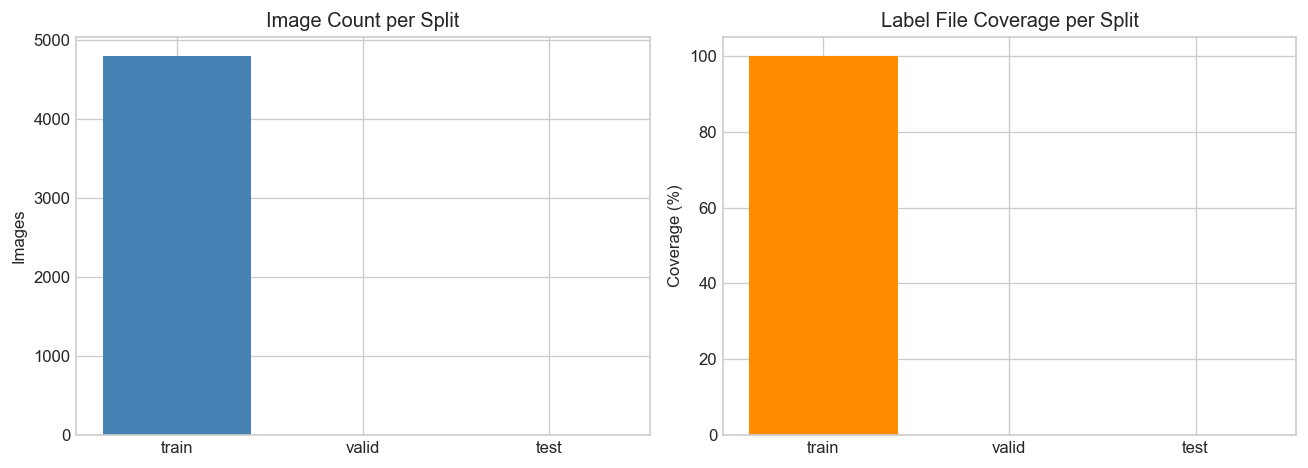


Split share of total images:
  train: 100.0%
  valid:   0.0%
  test :   0.0%


In [4]:
split_stats = []

for split in SPLITS:
    split_dir = resolve_split_dir(split)
    img_dir = split_dir / "images"
    label_dir = split_dir / "labels"

    images = list(img_dir.glob("*.*")) if img_dir.exists() else []
    labels = list(label_dir.glob("*.txt")) if label_dir.exists() else []

    split_stats.append(
        {
            "split": split,
            "images": len(images),
            "labels": len(labels),
            "label_coverage_%": (100 * len(labels) / len(images)) if images else 0,
        }
    )

if pd is not None:
    split_df = pd.DataFrame(split_stats)
    display(split_df)
else:
    for row in split_stats:
        print(row)

total_images = sum(x["images"] for x in split_stats)
missing_splits = [x["split"] for x in split_stats if x["images"] == 0]
if missing_splits:
    print(f"Note: No images found for splits: {', '.join(missing_splits)}")

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].bar([x["split"] for x in split_stats], [x["images"] for x in split_stats], color="steelblue")
axes[0].set_title("Image Count per Split")
axes[0].set_ylabel("Images")

axes[1].bar([x["split"] for x in split_stats], [x["label_coverage_%"] for x in split_stats], color="darkorange")
axes[1].set_title("Label File Coverage per Split")
axes[1].set_ylabel("Coverage (%)")
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

print("\nSplit share of total images:")
for row in split_stats:
    share = (100 * row["images"] / total_images) if total_images else 0
    print(f"  {row['split']:5s}: {share:5.1f}%")

## Build analysis tables from labels and images


In [5]:
instance_records = []
image_records = []

for split in SPLITS:
    split_dir = resolve_split_dir(split)
    img_dir = split_dir / "images"
    label_dir = split_dir / "labels"
    if not img_dir.exists() or not label_dir.exists():
        continue

    for img_path in img_dir.glob("*.*"):
        lbl_path = label_dir / f"{img_path.stem}.txt"

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w = img.shape[:2]
        image_info = {
            "split": split,
            "image_name": img_path.name,
            "width": int(w),
            "height": int(h),
            "aspect_ratio": float(w / h),
            "instances": 0,
        }

        if lbl_path.exists():
            with open(lbl_path, "r") as f:
                lines = [line.strip() for line in f if line.strip()]

            image_info["instances"] = len(lines)

            for line in lines:
                parts = line.split()
                cls = int(parts[0])
                coords = parts[1:]
                points = len(coords) // 2
                instance_records.append(
                    {
                        "split": split,
                        "image_name": img_path.name,
                        "class_id": cls,
                        "class_name": display_name_map.get(cls, f"Class_{cls}"),
                        "polygon_points": points,
                    }
                )

        image_records.append(image_info)

if pd is not None:
    instances_df = pd.DataFrame(instance_records)
    images_df = pd.DataFrame(image_records)
else:
    instances_df = instance_records
    images_df = image_records

print(f"Parsed {len(image_records)} images and {len(instance_records)} labeled instances.")

Parsed 4794 images and 67461 labeled instances.


## Class distribution and imbalance


,class_id,class_name,count
8,8,text,31121
17,17,icon,20726
9,9,button,4947
12,12,os_menu_bar,3843
16,16,text_input_field,2518
5,5,horizontal_swipe_menu,1474
14,14,general_input,892
0,0,auth_view,623
3,3,input_popup,320
10,10,top_header_bar,273


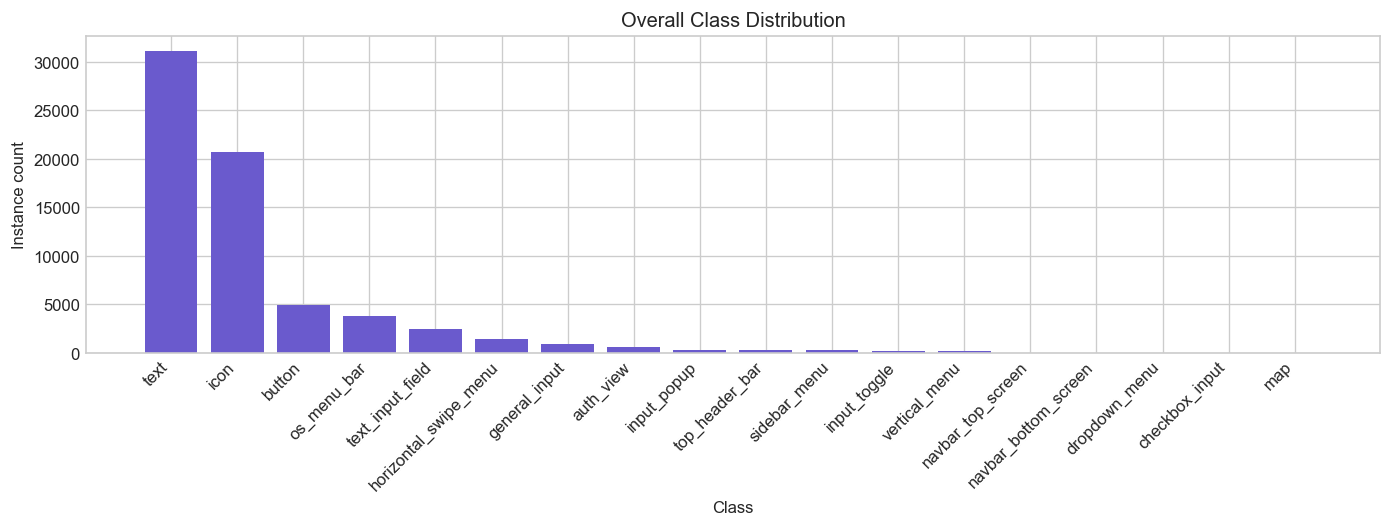

split,train
class_name,
auth_view,623
button,4947
checkbox_input,4
dropdown_menu,13
general_input,892
horizontal_swipe_menu,1474
icon,20726
input_popup,320
input_toggle,233


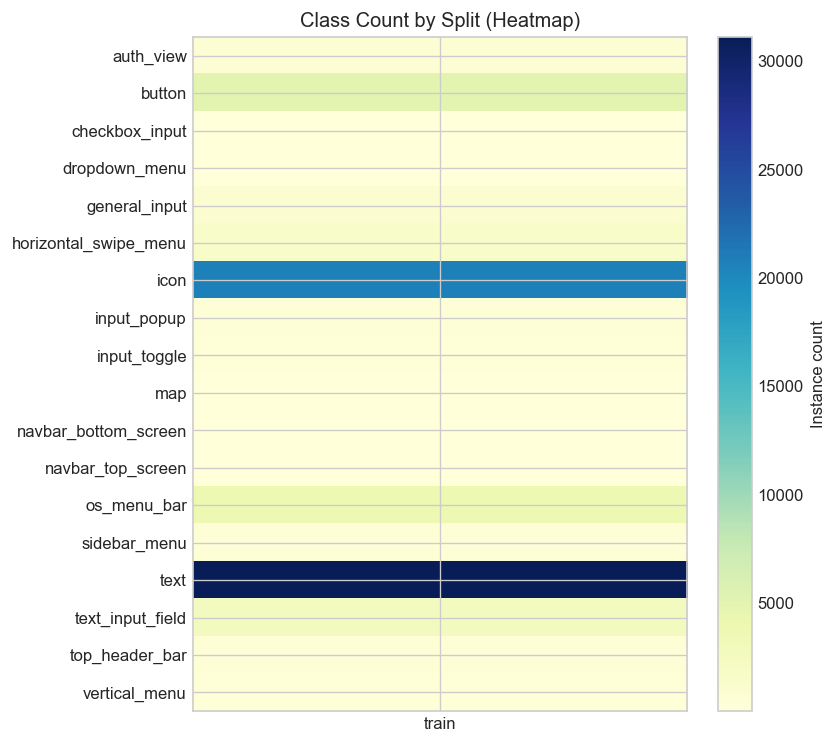

Class imbalance check:
  Most frequent class count:  31121
  Least frequent class count: 3
  Imbalance ratio (max/min):  10373.67x


In [6]:
if len(instance_records) == 0:
    print("No label instances found.")
else:
    if pd is not None:
        class_counts = (
            instances_df.groupby(["class_id", "class_name"]).size().reset_index(name="count")
            .sort_values("count", ascending=False)
        )
        display(class_counts)

        plt.figure(figsize=(max(8, 0.65 * len(class_counts)), 4.5))
        plt.bar(class_counts["class_name"], class_counts["count"], color="slateblue")
        plt.title("Overall Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Instance count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        split_class = (
            instances_df.groupby(["split", "class_name"]).size().reset_index(name="count")
            .pivot(index="class_name", columns="split", values="count")
            .fillna(0)
        )
        display(split_class)

        fig, ax = plt.subplots(figsize=(7, max(4, 0.35 * len(split_class))))
        im = ax.imshow(split_class.values, aspect="auto", cmap="YlGnBu")
        ax.set_xticks(range(len(split_class.columns)))
        ax.set_xticklabels(split_class.columns)
        ax.set_yticks(range(len(split_class.index)))
        ax.set_yticklabels(split_class.index)
        ax.set_title("Class Count by Split (Heatmap)")
        plt.colorbar(im, ax=ax, label="Instance count")
        plt.tight_layout()
        plt.show()

        max_count = class_counts["count"].max()
        min_count = class_counts["count"].min()
        imbalance_ratio = (max_count / min_count) if min_count > 0 else np.inf

        print("Class imbalance check:")
        print(f"  Most frequent class count:  {max_count}")
        print(f"  Least frequent class count: {min_count}")
        print(f"  Imbalance ratio (max/min):  {imbalance_ratio:.2f}x")
    else:
        cls_counts = defaultdict(int)
        split_cls_counts = {s: defaultdict(int) for s in SPLITS}
        for rec in instance_records:
            cls_counts[rec["class_name"]] += 1
            split_cls_counts[rec["split"]][rec["class_name"]] += 1

        labels = sorted(cls_counts.keys(), key=lambda x: cls_counts[x], reverse=True)
        counts = [cls_counts[x] for x in labels]

        plt.figure(figsize=(max(8, 0.65 * len(labels)), 4.5))
        plt.bar(labels, counts, color="slateblue")
        plt.title("Overall Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Instance count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        print("Top classes:")
        for name in labels[:10]:
            print(f"  {name:20s} {cls_counts[name]}")

## Image geometry


,width,height,aspect_ratio,instances
count,4794.000000,4794.000000,4794.000000,4794.000000
mean,947.947851,1670.532958,0.569445,14.071965
std,301.253198,557.085638,0.040031,9.067176
min,215.000000,469.000000,0.336763,2.000000
25%,720.000000,1280.000000,0.562500,7.000000
50%,1080.000000,1794.000000,0.562500,11.000000
75%,1242.000000,2208.000000,0.602007,19.000000
max,3140.000000,6056.000000,0.638655,60.000000


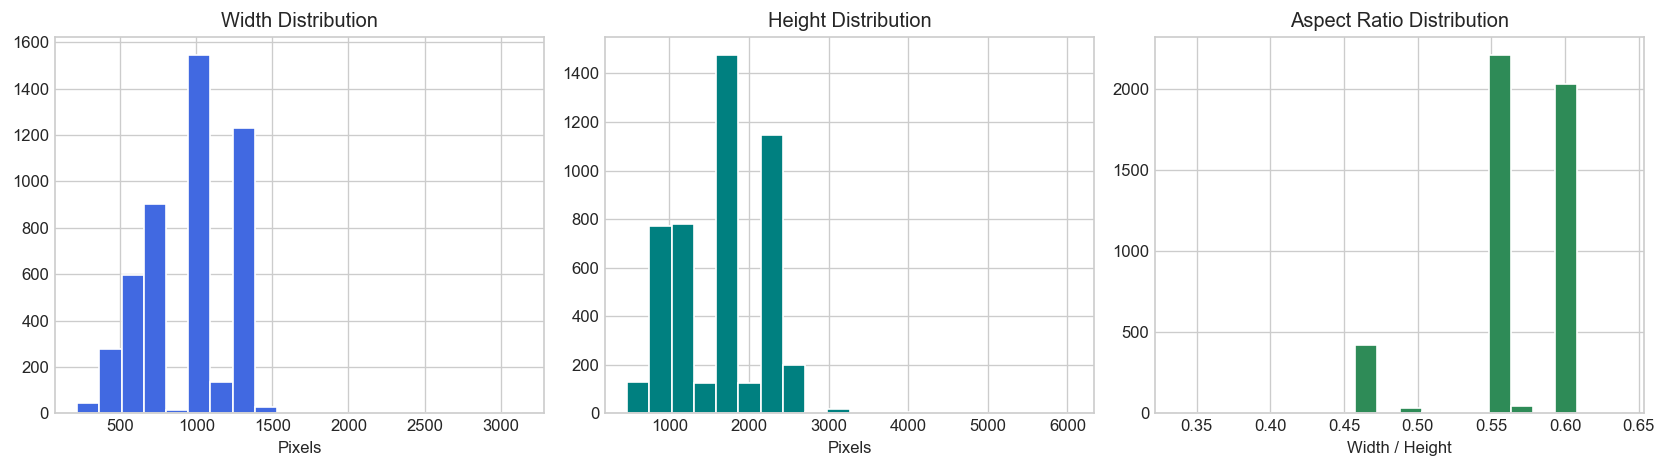

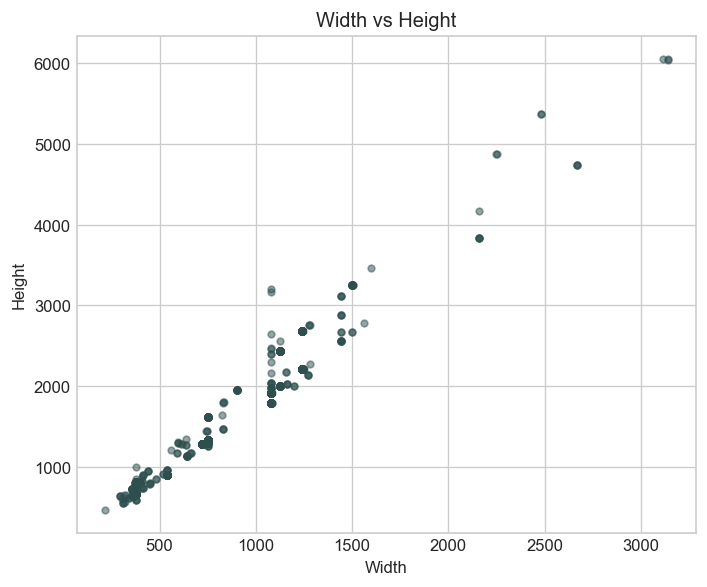

Key geometry stats:
  Width min/mean/max:  215 / 947.9 / 3140
  Height min/mean/max: 469 / 1670.5 / 6056
  Aspect min/mean/max: 0.34 / 0.57 / 0.64


In [7]:
if len(image_records) == 0:
    print("No images found.")
else:
    if pd is not None:
        display(images_df[["width", "height", "aspect_ratio", "instances"]].describe())

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        axes[0].hist(images_df["width"], bins=20, color="royalblue", edgecolor="white")
        axes[0].set_title("Width Distribution")
        axes[0].set_xlabel("Pixels")

        axes[1].hist(images_df["height"], bins=20, color="teal", edgecolor="white")
        axes[1].set_title("Height Distribution")
        axes[1].set_xlabel("Pixels")

        axes[2].hist(images_df["aspect_ratio"], bins=20, color="seagreen", edgecolor="white")
        axes[2].set_title("Aspect Ratio Distribution")
        axes[2].set_xlabel("Width / Height")

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.scatter(images_df["width"], images_df["height"], alpha=0.5, s=16, color="darkslategray")
        plt.title("Width vs Height")
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.tight_layout()
        plt.show()

        print("Key geometry stats:")
        print(f"  Width min/mean/max:  {images_df['width'].min()} / {images_df['width'].mean():.1f} / {images_df['width'].max()}")
        print(f"  Height min/mean/max: {images_df['height'].min()} / {images_df['height'].mean():.1f} / {images_df['height'].max()}")
        print(
            f"  Aspect min/mean/max: {images_df['aspect_ratio'].min():.2f} / "
            f"{images_df['aspect_ratio'].mean():.2f} / {images_df['aspect_ratio'].max():.2f}"
        )
    else:
        widths = [x["width"] for x in image_records]
        heights = [x["height"] for x in image_records]
        aspects = [x["aspect_ratio"] for x in image_records]

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))
        axes[0].hist(widths, bins=20, color="royalblue", edgecolor="white")
        axes[0].set_title("Width Distribution")
        axes[1].hist(heights, bins=20, color="teal", edgecolor="white")
        axes[1].set_title("Height Distribution")
        axes[2].hist(aspects, bins=20, color="seagreen", edgecolor="white")
        axes[2].set_title("Aspect Ratio Distribution")
        plt.tight_layout()
        plt.show()

## Segmentation complexity


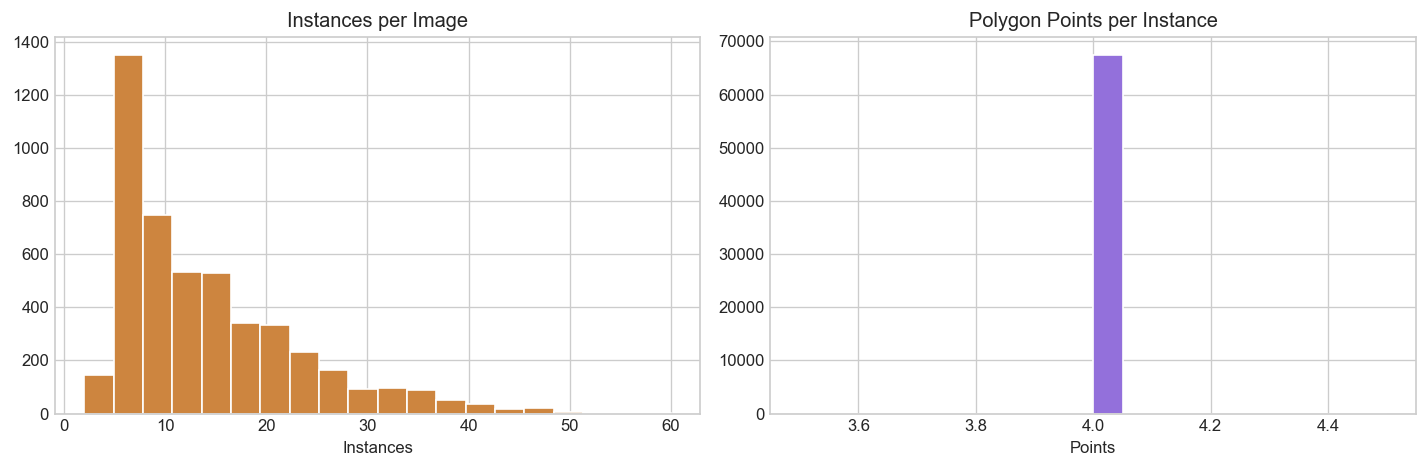

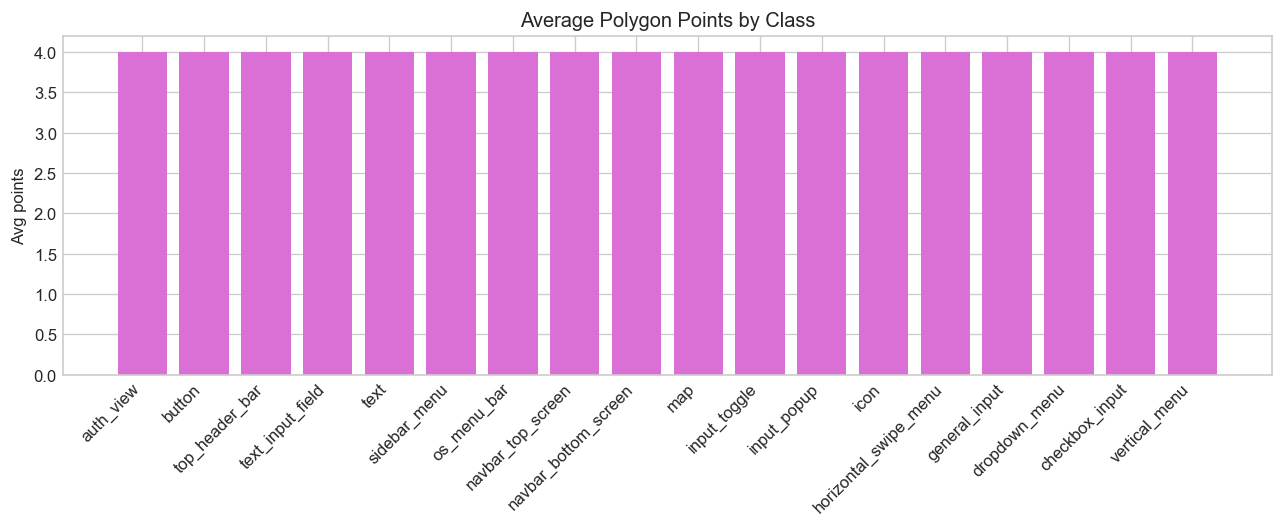

/var/folders/97/pp2kwyln5qq6rm7pkwn81wym0000gq/T/ipykernel_24206/950833711.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True, boxprops={"facecolor": "lightblue"})


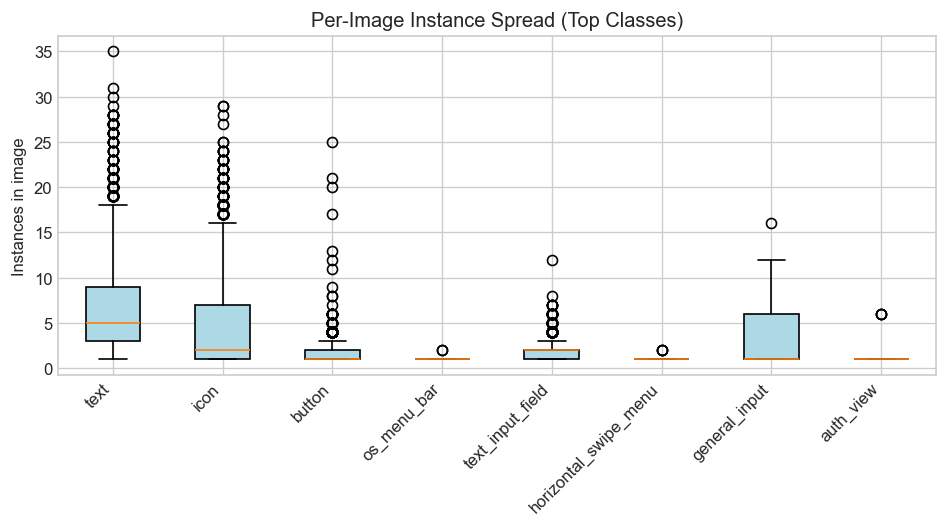

Complexity stats:
  Instances per image min/mean/max: 2 / 14.07 / 60
  Polygon points min/mean/max: 4 / 4.00 / 4


In [8]:
if len(instance_records) == 0:
    print("No segmentation annotations found.")
else:
    if pd is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        axes[0].hist(images_df["instances"], bins=20, color="peru", edgecolor="white")
        axes[0].set_title("Instances per Image")
        axes[0].set_xlabel("Instances")

        axes[1].hist(instances_df["polygon_points"], bins=20, color="mediumpurple", edgecolor="white")
        axes[1].set_title("Polygon Points per Instance")
        axes[1].set_xlabel("Points")

        plt.tight_layout()
        plt.show()

        per_class_points = (
            instances_df.groupby("class_name")["polygon_points"]
            .mean()
            .sort_values(ascending=False)
        )

        plt.figure(figsize=(max(8, 0.6 * len(per_class_points)), 4.5))
        plt.bar(per_class_points.index, per_class_points.values, color="orchid")
        plt.title("Average Polygon Points by Class")
        plt.ylabel("Avg points")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        class_image_counts = (
            instances_df.groupby(["image_name", "class_name"]).size().reset_index(name="count")
        )
        top_classes = (
            instances_df["class_name"].value_counts().head(min(8, instances_df["class_name"].nunique())).index.tolist()
        )

        data = []
        labels = []
        for cls_name in top_classes:
            per_image = class_image_counts[class_image_counts["class_name"] == cls_name]["count"].values
            if len(per_image) > 0:
                data.append(per_image)
                labels.append(cls_name)

        if data:
            plt.figure(figsize=(max(8, 0.8 * len(labels)), 4.5))
            plt.boxplot(data, labels=labels, patch_artist=True, boxprops={"facecolor": "lightblue"})
            plt.title("Per-Image Instance Spread (Top Classes)")
            plt.ylabel("Instances in image")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

        print("Complexity stats:")
        print(
            f"  Instances per image min/mean/max: {images_df['instances'].min()} / "
            f"{images_df['instances'].mean():.2f} / {images_df['instances'].max()}"
        )
        print(
            f"  Polygon points min/mean/max: {instances_df['polygon_points'].min()} / "
            f"{instances_df['polygon_points'].mean():.2f} / {instances_df['polygon_points'].max()}"
        )
    else:
        inst_per_img = [x["instances"] for x in image_records]
        points = [x["polygon_points"] for x in instance_records]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].hist(inst_per_img, bins=20, color="peru", edgecolor="white")
        axes[0].set_title("Instances per Image")
        axes[1].hist(points, bins=20, color="mediumpurple", edgecolor="white")
        axes[1].set_title("Polygon Points per Instance")
        plt.tight_layout()
        plt.show()

## Qualitative sample review (image + mask overlay)


/var/folders/97/pp2kwyln5qq6rm7pkwn81wym0000gq/T/ipykernel_24206/3909517912.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(num_classes, 1))


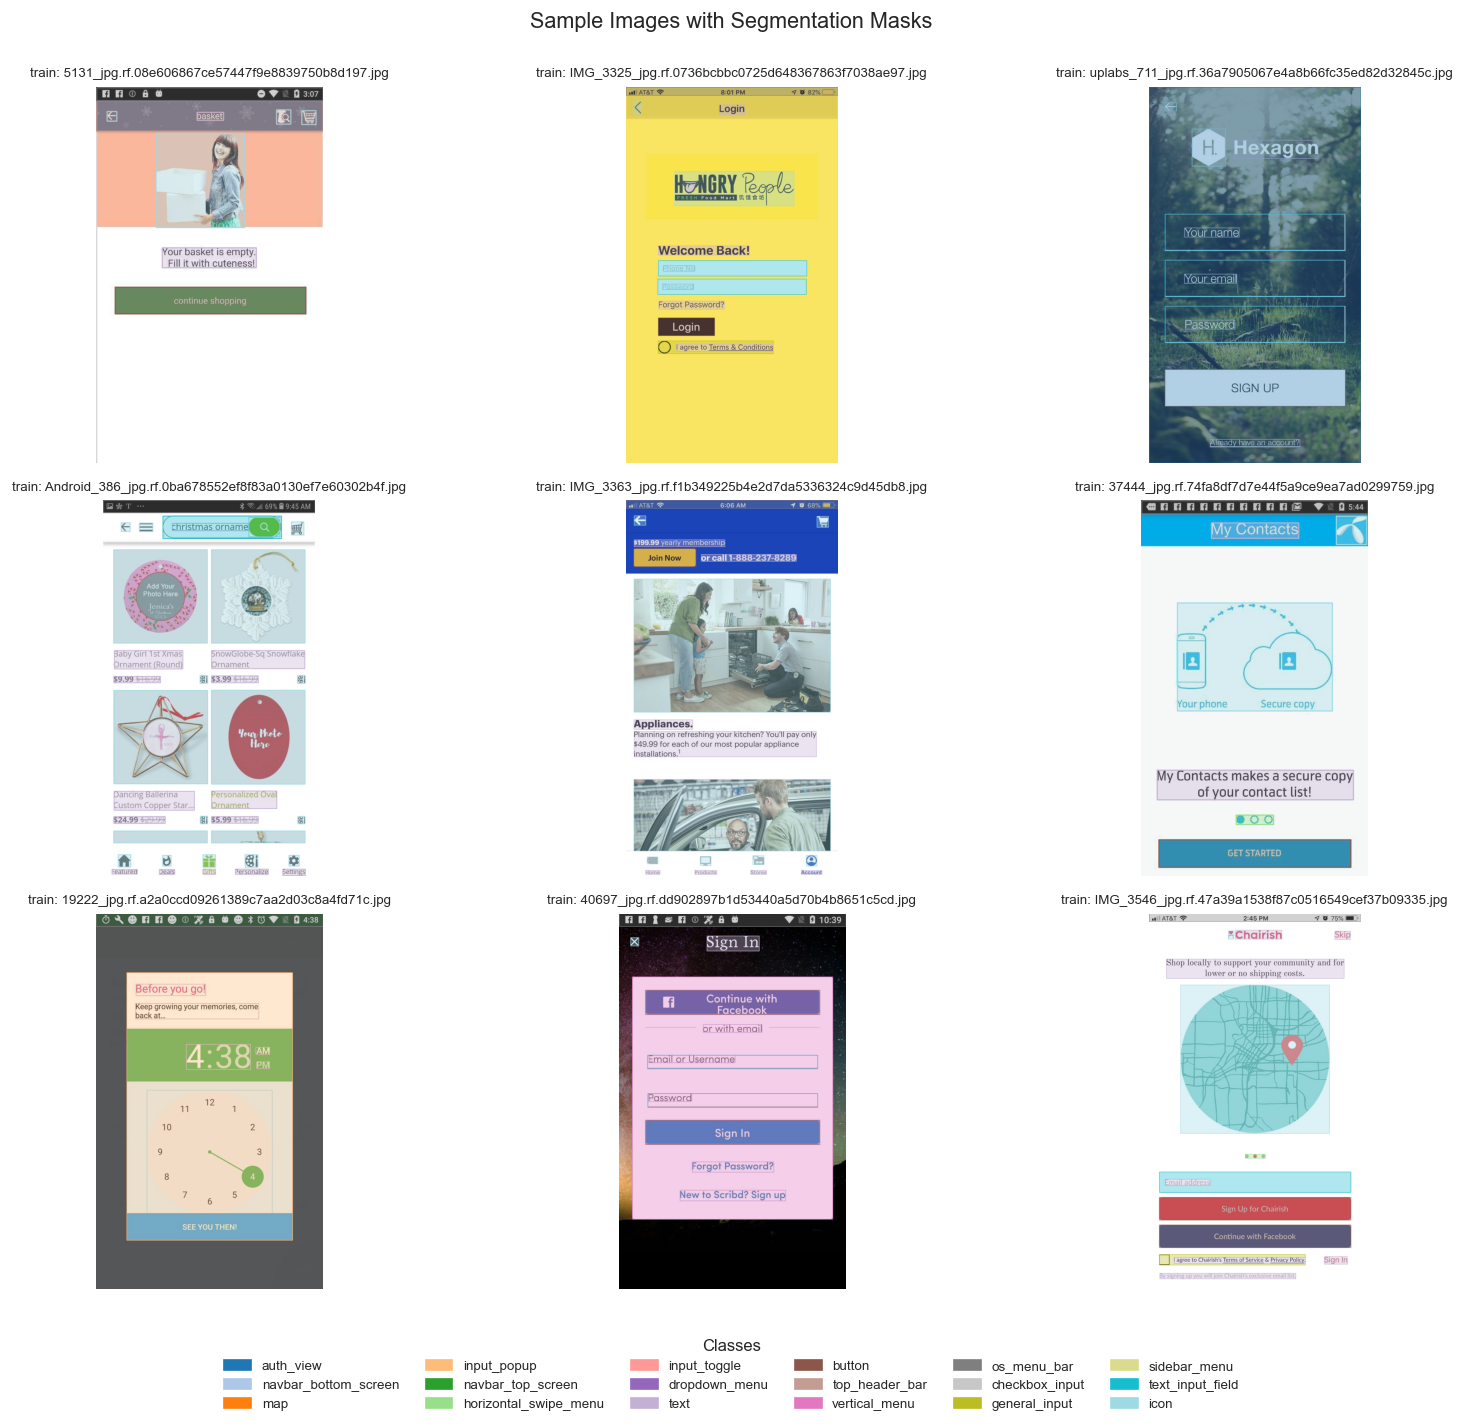

In [9]:
N_SAMPLES = 9
COLS = 3

pairs = []
for split in SPLITS:
    split_dir = resolve_split_dir(split)
    img_dir = split_dir / "images"
    label_dir = split_dir / "labels"
    if not img_dir.exists() or not label_dir.exists():
        continue

    for img_path in img_dir.glob("*.*"):
        lbl_path = label_dir / f"{img_path.stem}.txt"
        if lbl_path.exists():
            pairs.append((split, img_path, lbl_path))

if not pairs:
    print("No image/label pairs found.")
else:
    sample = random.sample(pairs, min(N_SAMPLES, len(pairs)))

    cmap = plt.cm.get_cmap("tab20", max(num_classes, 1))
    colors_bgr = [tuple(int(c * 255) for c in cmap(i)[:3][::-1]) for i in range(num_classes)]

    rows = (len(sample) + COLS - 1) // COLS
    fig, axes = plt.subplots(rows, COLS, figsize=(COLS * 5, rows * 4))
    axes = np.array(axes).reshape(-1)

    for ax, (split, img_path, lbl_path) in zip(axes, sample):
        img = cv2.imread(str(img_path))
        if img is None:
            ax.axis("off")
            continue

        h, w = img.shape[:2]
        overlay = img.copy()

        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue

                cls = int(parts[0])
                coords = list(map(float, parts[1:]))
                if len(coords) < 6:
                    continue

                pts = np.array(
                    [(coords[i] * w, coords[i + 1] * h) for i in range(0, len(coords), 2)],
                    dtype=np.int32,
                )

                color = colors_bgr[cls % len(colors_bgr)]
                cv2.fillPoly(overlay, [pts], color)
                cv2.polylines(img, [pts], True, color, 2)

        blended = cv2.addWeighted(overlay, 0.35, img, 0.65, 0)
        ax.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
        ax.set_title(f"{split}: {img_path.name}", fontsize=8)
        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    legend_handles = [
        mpatches.Patch(color=cmap(i)[:3], label=display_name_map.get(i, f"Class_{i}"))
        for i in range(num_classes)
    ]
    fig.legend(
        handles=legend_handles,
        loc="lower center",
        ncol=min(6, max(1, num_classes)),
        fontsize=8,
        title="Classes",
        bbox_to_anchor=(0.5, 0.0),
    )

    fig.suptitle("Sample Images with Segmentation Masks", fontsize=13)
    plt.tight_layout(rect=[0, 0.08, 1, 0.98])
    plt.show()

## Build multi-example-per-label folder (with bounding boxes)


In [10]:
from pathlib import Path
import re
import shutil

RESET_OUTPUT_DIR = True
EXAMPLES_PER_CLASS = 3
OUTPUT_DIR = DATASET_DIR / "examples_one_per_label"
OUTPUT_IMG_DIR = OUTPUT_DIR / "images"
OUTPUT_LBL_DIR = OUTPUT_DIR / "labels"


def sanitize_name(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(name)).strip("_") or "unnamed"


if RESET_OUTPUT_DIR and OUTPUT_DIR.exists():
    shutil.rmtree(OUTPUT_DIR)

OUTPUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_LBL_DIR.mkdir(parents=True, exist_ok=True)

class_to_examples = {cls: [] for cls in range(num_classes)}

for split in SPLITS:
    split_dir = resolve_split_dir(split)
    img_dir = split_dir / "images"
    label_dir = split_dir / "labels"

    if not img_dir.exists() or not label_dir.exists():
        continue

    for lbl_path in sorted(label_dir.glob("*.txt")):
        image_candidates = sorted(img_dir.glob(f"{lbl_path.stem}.*"))
        if not image_candidates:
            continue

        img_path = image_candidates[0]
        src_image_str = str(img_path)

        present_classes = set()
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                try:
                    cls = int(parts[0])
                except ValueError:
                    continue
                if 0 <= cls < num_classes:
                    present_classes.add(cls)

        for cls in present_classes:
            examples = class_to_examples[cls]
            if len(examples) >= EXAMPLES_PER_CLASS:
                continue
            if any(e["source_image"] == src_image_str for e in examples):
                continue

            examples.append(
                {
                    "class_id": cls,
                    "class_name": display_name_map.get(cls, f"Class_{cls}"),
                    "split": split,
                    "source_image": src_image_str,
                    "source_label": str(lbl_path),
                }
            )

        if all(len(class_to_examples[c]) >= EXAMPLES_PER_CLASS for c in range(num_classes)):
            break

    if all(len(class_to_examples[c]) >= EXAMPLES_PER_CLASS for c in range(num_classes)):
        break

manifest_rows = []
for cls in range(num_classes):
    class_name = sanitize_name(display_name_map.get(cls, f"Class_{cls}"))
    examples = class_to_examples.get(cls, [])

    for sample_index, example in enumerate(examples, start=1):
        src_img = Path(example["source_image"])
        src_lbl = Path(example["source_label"])

        out_img = OUTPUT_IMG_DIR / f"{cls:02d}_{class_name}_{sample_index:02d}{src_img.suffix.lower()}"
        out_lbl = OUTPUT_LBL_DIR / f"{cls:02d}_{class_name}_{sample_index:02d}.txt"

        img = cv2.imread(str(src_img))
        if img is None:
            continue

        h, w = img.shape[:2]
        annotated = img.copy()
        class_lines = []
        box_count = 0

        with open(src_lbl, "r") as f:
            for raw_line in f:
                line = raw_line.strip()
                parts = line.split()
                if not parts:
                    continue

                try:
                    cls_id = int(parts[0])
                except ValueError:
                    continue

                if cls_id != cls:
                    continue

                coords = parts[1:]
                if len(coords) < 6:
                    continue

                try:
                    coords = list(map(float, coords))
                except ValueError:
                    continue

                xs = [coords[i] * w for i in range(0, len(coords), 2)]
                ys = [coords[i + 1] * h for i in range(0, len(coords), 2)]
                if not xs or not ys:
                    continue

                x_min = int(max(0, min(xs)))
                y_min = int(max(0, min(ys)))
                x_max = int(min(w - 1, max(xs)))
                y_max = int(min(h - 1, max(ys)))

                cv2.rectangle(annotated, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(
                    annotated,
                    f"{cls}: {example['class_name']}",
                    (x_min, max(18, y_min - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.55,
                    (0, 255, 0),
                    2,
                    cv2.LINE_AA,
                )

                class_lines.append(line)
                box_count += 1

        if box_count == 0:
            continue

        cv2.imwrite(str(out_img), annotated)
        with open(out_lbl, "w") as f:
            for line in class_lines:
                f.write(line + "\n")

        manifest_rows.append(
            {
                "class_id": cls,
                "class_name": example["class_name"],
                "sample_index": sample_index,
                "split": example["split"],
                "box_count": box_count,
                "output_image": str(out_img),
                "output_label": str(out_lbl),
                "source_image": example["source_image"],
                "source_label": example["source_label"],
            }
        )

shortfall_classes = [
    {
        "class_id": cls,
        "class_name": display_name_map.get(cls, f"Class_{cls}"),
        "available_examples": len(class_to_examples.get(cls, [])),
        "requested_examples": EXAMPLES_PER_CLASS,
    }
    for cls in range(num_classes)
    if len(class_to_examples.get(cls, [])) < EXAMPLES_PER_CLASS
]

requested_total = num_classes * EXAMPLES_PER_CLASS

if pd is not None:
    manifest_df = pd.DataFrame(manifest_rows)
    if not manifest_df.empty:
        manifest_df = manifest_df.sort_values(["class_id", "sample_index"]).reset_index(drop=True)

    manifest_path = OUTPUT_DIR / "manifest.csv"
    manifest_df.to_csv(manifest_path, index=False)

    print(
        f"Created {len(manifest_df)} annotated examples in: {OUTPUT_DIR.resolve()} "
        f"(requested {requested_total})."
    )
    print(f"Manifest saved to: {manifest_path.resolve()}")
    display(manifest_df)

    if shortfall_classes:
        print("\nClasses with fewer than requested examples:")
        display(pd.DataFrame(shortfall_classes))
else:
    manifest_path = OUTPUT_DIR / "manifest.csv"
    with open(manifest_path, "w") as f:
        f.write(
            "class_id,class_name,sample_index,split,box_count,output_image,"
            "output_label,source_image,source_label\n"
        )
        for row in sorted(manifest_rows, key=lambda x: (x["class_id"], x["sample_index"])):
            f.write(
                f"{row['class_id']},{row['class_name']},{row['sample_index']},"
                f"{row['split']},{row['box_count']},{row['output_image']},"
                f"{row['output_label']},{row['source_image']},{row['source_label']}\n"
            )

    print(
        f"Created {len(manifest_rows)} annotated examples in: {OUTPUT_DIR.resolve()} "
        f"(requested {requested_total})."
    )
    print(f"Manifest saved to: {manifest_path.resolve()}")

    if shortfall_classes:
        print("\nClasses with fewer than requested examples:")
        for row in shortfall_classes:
            print(
                f"  {row['class_id']}: {row['class_name']} "
                f"({row['available_examples']}/{row['requested_examples']})"
            )

Created 54 annotated examples in: /Users/frank/School/CPSC 542/final project/dataset_cleaned/examples_one_per_label (requested 54).
Manifest saved to: /Users/frank/School/CPSC 542/final project/dataset_cleaned/examples_one_per_label/manifest.csv


,class_id,class_name,sample_index,split,box_count,output_image,output_label,source_image,source_label
0,0,auth_view,1,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/10474_jpg.rf.76a3...,dataset_cleaned/train/labels/10474_jpg.rf.76a3...
1,0,auth_view,2,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/10624_jpg.rf.0336...,dataset_cleaned/train/labels/10624_jpg.rf.0336...
2,0,auth_view,3,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/1071_jpg.rf.d8799...,dataset_cleaned/train/labels/1071_jpg.rf.d8799...
3,1,navbar_bottom_screen,1,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/10244_jpg.rf.dd8c...,dataset_cleaned/train/labels/10244_jpg.rf.dd8c...
4,1,navbar_bottom_screen,2,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/10588_jpg.rf.857a...,dataset_cleaned/train/labels/10588_jpg.rf.857a...
5,1,navbar_bottom_screen,3,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/1142_jpg.rf.5836e...,dataset_cleaned/train/labels/1142_jpg.rf.5836e...
6,2,map,1,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/2209_jpg.rf.f820d...,dataset_cleaned/train/labels/2209_jpg.rf.f820d...
7,2,map,2,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/2210_jpg.rf.6dd98...,dataset_cleaned/train/labels/2210_jpg.rf.6dd98...
8,2,map,3,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/29773_jpg.rf.f982...,dataset_cleaned/train/labels/29773_jpg.rf.f982...
9,3,input_popup,1,train,1,dataset_cleaned/examples_one_per_label/images/...,dataset_cleaned/examples_one_per_label/labels/...,dataset_cleaned/train/images/10055_jpg.rf.fa12...,dataset_cleaned/train/labels/10055_jpg.rf.fa12...
